In [1]:
# import the modules

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample, shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### Define the following functions as per the description, so that they can be called later to perform the tasks.

In [2]:
# to treat missing values

def treat_null_values(df, method):
    """Treats the missing values in the dataframe.
    
    This function accepts a dataframe and the method to treat the missing value.
    Depending on the method passed, impute/drop the missing values.
        
    Keyword arguments:
    df -- pandas dataframe for which we want to treat the missing values
    method -- method to treat the missing values
    """
    if method=='impute':
        df.fillna('mean', inplace=True)
    elif method=='drop':
        df.dropna(inplace=True)
    else:
        raise NameError('Enter valid method: impute or drop')
    
    return df

In [3]:
# to seperate the numerical and categorical columns

def num_and_cat_columns(df):
    """Return seperate list of numerical & categorical columns.
    
    This function accepts a dataframe and returns two lists,
    one containing the names of numerical columns(num_cols) and the other categorical columns(cat_cols).
        
    Keyword arguments:
    df -- pandas dataframe for which we want the list of columns
    
    Returns:
    num_cols -- list of numerical columns
    cat_cols -- list of categorical columns
    """
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    
    return num_cols, cat_cols

In [4]:
# to encode the categorical column so as to convert them to numeric.
    
def encode_category(df, enc, col, method):
    """Encodes the categorical columns of the dataframe.
    
    This function accepts a dataframe and columns to be encoded along with the method to be used for encoding.
        
    Keyword arguments:
    df -- pandas dataframe for which we want to encode the columns -- this dataframe would be transformed
    enc -- the encoder - fitted on the train data
    col -- list of columns that is to be encoded
    method -- method to be used while encoding
    
    Returns:
    df1 -- the encoded dataframe
    """
    df1 = pd.get_dummies(df[col], drop_first=True)
    
    return df1

In [5]:
# to clean the dollar sign from the currency column & convert it to float.
    
def clean_dollar(df, col):
    """Removes "$" sign from a column & converts it to float.
    
    This function accepts a dataframe and columns with $ sign to be converted to float.
        
    Keyword arguments:
    df -- pandas dataframe for which we want to encode the columns
    col -- list of columns that is to be converted
    
    Returns:
    df -- the converted dataframe
    """
    for icol in col:
        df[icol] = df[icol].str.replace('$', '').astype(float)
    
    return df

In [6]:
# to visualize distributions of the column(s) by plotting them.
    
def plot_distribution(kind_, df, col):
    """Plot distribution of the column(s).
    
    This function will plot a chart of the passed column as the 'kind' specified in kind_.
    You can pass multiple columns to this function.
        
    Keyword arguments:
    knid_ -- 'kind' of chart that will be plotted
    df -- pandas dataframe which has the data
    *col -- list of all the features for which we want to plot the distribution
    """
    if kind_ == 'hist':
        df[col].hist(figsize=(10, 6))
    else:
        df[col].plot(kind=kind_, figsize=(10, 6))
        
    plt.tight_layout()
    plt.show()    

In [7]:
# to apply transformation to any column

def transform_column(df, col, transformation):
    """Apply transformation to the column(s).
    
    This function will apply the passed transformation to the given dataframe & columns.
    You can pass multiple columns to this function.
        
    Keyword arguments:
    df -- pandas dataframe which has the data
    col -- list of all the features for which we want to apply the transformation
    transformation -- the transformation we want to apply
    """
    if transformation=='log':
        for icol in col:
            df[icol] = np.log1p(df[icol])
    
    if transformation=='sqrt':
        for icol in col:
            df[icol] = np.sqrt(df[icol])
    
    return df    

In [8]:
# to check outliers using box plot

def check_outliers(df, col, cat):
    """Check outliers through boxplot.
    
    This function plots and displays the boxplot of the feature col vs all the categories defined. 
    Check for any outlier present.
        
    Keyword arguments:
    df -- pandas dataframe which has the data
    col -- the feature for which we want to plot the boxplot
    cat -- the list of features (categorical) by which we want to check the outliers (for each category in each feature)
    """
    
    

In [9]:
# to fit the model & return the score

def fit_model(X_train, X_test, y_train, y_test, model):
    """Fit the model & return the score of the fitted model.
    
    This function accepts the test & train data and fits the given model to it and returns the score of the model.
    
    Keyword arguments:
    X_train -- Train feature
    X_test -- Test/Validation feature
    y_train -- Train target
    y_test -- Tets/Validation target
    model -- the model to be fitted
    
    Returns:
    r2 -- R-Square of the fitted model    
    """
    model.fit(X_train, y_train)
    
    return model

### Read the dataset. Take a look at the dataset. 

* Check the data types present in the dataframe.
* Call the num_and_cat_columns() with train as the parameter and store the results.
* Are there any missing values? Are there any Outliers? How do you want to treat them?


In [27]:
data = pd.read_csv('./train.csv')
data.head()

,Id,Year Type,Year,Organization Group,Department,Union,Job Family,Job,Employee Identifier,Retirement,Health and Dental,Other Benefits,Total Compensation
0,0,Calendar,2018,Community Health,NaN,"Prof & Tech Eng, Local 21",Information Systems,IS Business Analyst-Principal,8594384,$0.0,$13527.66,$0.0,0.00
1,1,Calendar,2014,"Public Works, Transportation & Commerce",MTA Municipal Transprtn Agncy,"SEIU - Miscellaneous, Local 1021",Public Service Aide,Publ Svc Aide-Asst To Prof,22142,$0.0,$3995.56,$875.27,16176.35
2,2,Fiscal,2018,General City Responsibilities,NaN,"SEIU, Local 1021, Misc","Payroll, Billing & Accounting",Senior Account Clerk,8512172,$0.0,$0.0,$0.0,248.30
3,3,Fiscal,2015,Community Health,DPH Public Health,"SEIU - Miscellaneous, Local 1021",Purchasing & Storekeeping,Sr Materials & Supplies Sprv,47593,$11671.59,$10680.55,$4400.24,80020.86
4,4,Fiscal,2014,Community Health,DPH Public Health,"SEIU - Miscellaneous, Local 1021",Hospital Administration,Medical Records Technician,47549,$14617.66,$12464.61,$5562.09,101207.38


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567103 entries, 0 to 567102
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id                   567103 non-null  int64  
 1   Year Type            567103 non-null  object 
 2   Year                 567103 non-null  int64  
 3   Organization Group   567103 non-null  object 
 4   Department           272038 non-null  object 
 5   Union                566758 non-null  object 
 6   Job Family           567103 non-null  object 
 7   Job                  567100 non-null  object 
 8   Employee Identifier  567103 non-null  int64  
 9   Retirement           567103 non-null  object 
 10  Health and Dental    567103 non-null  object 
 11  Other Benefits       567103 non-null  object 
 12  Total Compensation   567103 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 56.2+ MB


In [29]:
data.describe()

,Id,Year,Employee Identifier,Total Compensation
count,567103.000000,567103.000000,5.671030e+05,567103.000000
mean,283551.000000,2016.718106,4.502940e+06,82952.016002
std,163708.679192,1.983861,4.306688e+06,74338.078988
min,0.000000,2013.000000,1.000000e+00,-42615.240000
25%,141775.500000,2015.000000,2.959550e+04,6946.620000
50%,283551.000000,2017.000000,8.497001e+06,78706.040000
75%,425326.500000,2018.000000,8.556148e+06,133852.340000
max,567102.000000,2020.000000,1.223014e+07,807175.090000


In [30]:
data.describe(include='object')

,Year Type,Organization Group,Department,Union,Job Family,Job,Retirement,Health and Dental,Other Benefits
count,567103,567103,272038,566758,567103,567100,567103,567103,567103
unique,2,7,56,121,59,1123,227345,115380,272977
top,Calendar,"Public Works, Transportation & Commerce",DPH Public Health,"SEIU, Local 1021, Misc",Nursing,Transit Operator,$0.0,$0.0,$0.0
freq,325445,143163,59048,112750,55690,36209,171690,95338,99592


In [31]:
data.isnull().sum()/len(data) * 100

Id                      0.000000
Year Type               0.000000
Year                    0.000000
Organization Group      0.000000
Department             52.030231
Union                   0.060836
Job Family              0.000000
Job                     0.000529
Employee Identifier     0.000000
Retirement              0.000000
Health and Dental       0.000000
Other Benefits          0.000000
Total Compensation      0.000000
dtype: float64

In [32]:
# Drop Department as it has 52% missing values

data = data.drop(columns=['Department'])
data.columns

Index(['Id', 'Year Type', 'Year', 'Organization Group', 'Union', 'Job Family',
       'Job', 'Employee Identifier', 'Retirement', 'Health and Dental',
       'Other Benefits', 'Total Compensation'],
      dtype='object')

In [33]:
# Job and Union contains very small fraction of missing values 
# hence its better to drop those rows without loosing much of an information

data = treat_null_values(data, 'drop')
data.isnull().sum()

Id                     0
Year Type              0
Year                   0
Organization Group     0
Union                  0
Job Family             0
Job                    0
Employee Identifier    0
Retirement             0
Health and Dental      0
Other Benefits         0
Total Compensation     0
dtype: int64

In [34]:
num_cols, cat_cols = num_and_cat_columns(data)

print(num_cols)
print(cat_cols)

['Id', 'Year', 'Employee Identifier', 'Total Compensation']
['Year Type', 'Organization Group', 'Union', 'Job Family', 'Job', 'Retirement', 'Health and Dental', 'Other Benefits']


In [35]:
data.shape

(566755, 12)

### Visualize the data

- Check for the categorical & continuous features. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots.
- Clean the data and apply some data preprocessing techniques

In [36]:
# Code starts here

# Have a look at the features, check the type where any currency is involved. 
# We have columns with compensations stored in form of strings. We need to clean it and convert this to numeric. 
# Call the clean_dollar() to do the same.
col_list = ['Retirement', 'Health and Dental', 'Other Benefits']

data = clean_dollar(data, col_list)
data.head()

,Id,Year Type,Year,Organization Group,Union,Job Family,Job,Employee Identifier,Retirement,Health and Dental,Other Benefits,Total Compensation
0,0,Calendar,2018,Community Health,"Prof & Tech Eng, Local 21",Information Systems,IS Business Analyst-Principal,8594384,0.00,13527.66,0.00,0.00
1,1,Calendar,2014,"Public Works, Transportation & Commerce","SEIU - Miscellaneous, Local 1021",Public Service Aide,Publ Svc Aide-Asst To Prof,22142,0.00,3995.56,875.27,16176.35
2,2,Fiscal,2018,General City Responsibilities,"SEIU, Local 1021, Misc","Payroll, Billing & Accounting",Senior Account Clerk,8512172,0.00,0.00,0.00,248.30
3,3,Fiscal,2015,Community Health,"SEIU - Miscellaneous, Local 1021",Purchasing & Storekeeping,Sr Materials & Supplies Sprv,47593,11671.59,10680.55,4400.24,80020.86
4,4,Fiscal,2014,Community Health,"SEIU - Miscellaneous, Local 1021",Hospital Administration,Medical Records Technician,47549,14617.66,12464.61,5562.09,101207.38


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566755 entries, 0 to 567102
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id                   566755 non-null  int64  
 1   Year Type            566755 non-null  object 
 2   Year                 566755 non-null  int64  
 3   Organization Group   566755 non-null  object 
 4   Union                566755 non-null  object 
 5   Job Family           566755 non-null  object 
 6   Job                  566755 non-null  object 
 7   Employee Identifier  566755 non-null  int64  
 8   Retirement           566755 non-null  float64
 9   Health and Dental    566755 non-null  float64
 10  Other Benefits       566755 non-null  float64
 11  Total Compensation   566755 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 56.2+ MB


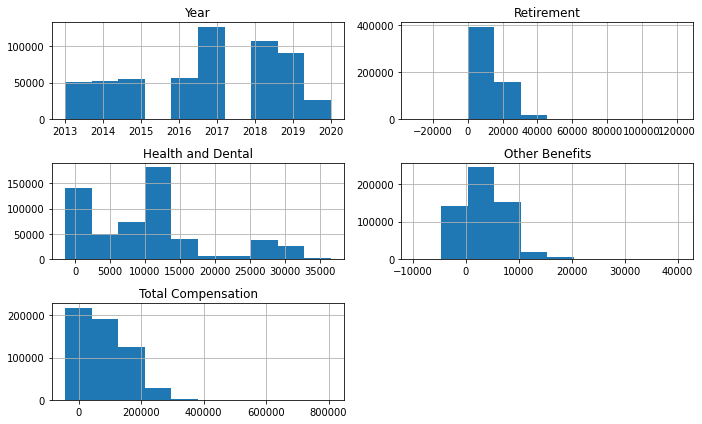

In [38]:
# Check the distribution of certain columns you might find of interest. 
# This can be done by calling the plot_distribution(). 
plot_cols = ['Year', 'Retirement', 'Health and Dental', 'Other Benefits', 'Total Compensation']

plot_distribution('hist', data, plot_cols)

In [39]:
# Apply some good transformation if required. Call transform_column() to do the same.

# data = transform_column(data, plot_cols[1: ], 'sqrt')
# plot_distribution('hist', data, plot_cols)

In [40]:
# Before we proceed with the model fitting, we need to get rid of the categorical columns.
# We can use One Hot Encoding or Label Encoding to convert the categorical columns to numeric.
#Call the encode_category() with the list of columns and the method of encoding to do the same.
cat_cols = data.select_dtypes(include='object').columns.tolist()
enc = OneHotEncoder()

data_enc = encode_category(data, enc, cat_cols, 'ohe')
data_enc.head()

,Year Type_Fiscal,Organization Group_Culture & Recreation,Organization Group_General Administration & Finance,Organization Group_General City Responsibilities,Organization Group_Human Welfare & Neighborhood Development,Organization Group_Public Protection,"Organization Group_Public Works, Transportation & Commerce","Union_Automotive Machinists, Local 1414","Union_BrickLayers, Local 3","Union_Bricklayers, Local 3",...,Job_Wharfinger I/II,Job_Window Cleaner,Job_Window Cleaner Supervisor,Job_Wire Rope Cable Maint Mechanic,Job_Wire Rope Cable Maint Sprv,Job_WireRopeCable Maint Mech Train,Job_Worker's Comp Supervisor 1,Job_Worker's Compensation Adjuster,Job_X-Ray Laboratory Aide,Job_Youth Comm Advisor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
data.isnull().sum()

Id                     0
Year Type              0
Year                   0
Organization Group     0
Union                  0
Job Family             0
Job                    0
Employee Identifier    0
Retirement             0
Health and Dental      0
Other Benefits         0
Total Compensation     0
dtype: int64

In [42]:
data = data.select_dtypes(include=np.number).join(data_enc)
data.head()

,Id,Year,Employee Identifier,Retirement,Health and Dental,Other Benefits,Total Compensation,Year Type_Fiscal,Organization Group_Culture & Recreation,Organization Group_General Administration & Finance,...,Job_Wharfinger I/II,Job_Window Cleaner,Job_Window Cleaner Supervisor,Job_Wire Rope Cable Maint Mechanic,Job_Wire Rope Cable Maint Sprv,Job_WireRopeCable Maint Mech Train,Job_Worker's Comp Supervisor 1,Job_Worker's Compensation Adjuster,Job_X-Ray Laboratory Aide,Job_Youth Comm Advisor
0,0,2018,8594384,0.00,13527.66,0.00,0.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2014,22142,0.00,3995.56,875.27,16176.35,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2018,8512172,0.00,0.00,0.00,248.30,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2015,47593,11671.59,10680.55,4400.24,80020.86,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2014,47549,14617.66,12464.61,5562.09,101207.38,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Now since we have encoded all the categorical columns, there shouldn't be any left in the data.
# Check the same by calling num_and_cat_columns()
num_cols, cat_cols = num_and_cat_columns(data)

print(cat_cols)

[]


### Model building

- Separate the features and target.
- Now let's come to the actual task, using linear regression, predict the `Total Compensation`. Use different techniques you have learned to imporove the performance of the model.
- Try improving upon the `r2_score` (R-Square) using different parameters that give the best score. Call the `fit_model()` with respective parameters.



In [44]:
# Code Starts here
X = data.drop(columns=['Total Compensation'])
y = data['Total Compensation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model_fitted = fit_model(X_train, X_test, y_train, y_test, model)
#print(r2_score)
# Code ends here

In [45]:
y_pred = model_fitted.predict(X_test)
y_pred_train = model_fitted.predict(X_train)

# # Evaluate the rmse score
print(f'R2 Score ==> Train: {round(r2_score(y_train, y_pred_train), 4)} | Test: {round(r2_score(y_test, y_pred), 4)}')

R2 Score ==> Train: 0.9586 | Test: 0.959


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [58]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,Id,Year Type,Year,Organization Group,Department,Union,Job Family,Job,Employee Identifier,Retirement,Health and Dental,Other Benefits
0,0,Calendar,2017,"Public Works, Transportation & Commerce",NaN,"Electrical Workers, Local 6",Journeyman Trade,Electrical Line Worker,8549078,$0.0,$13051.16,$0.0
1,1,Calendar,2019,Public Protection,NaN,"SEIU, Local 1021, Misc",Correction & Detention,"Counselor, Juvenile Hall PERS",8546443,$21487.97,$28361.72,$753.13
2,2,Fiscal,2018,Community Health,NaN,"SEIU, Local 1021, Misc",Dietary & Food,Food Service Worker,8512207,$12468.31,$13863.98,$4464.84
3,3,Fiscal,2018,Public Protection,NaN,"SEIU, Local 1021, Misc",Correction & Detention,"Counselor, Juvenile Hall SFERS",8542154,$0.0,$0.0,$1787.63
4,4,Fiscal,2017,Public Protection,POL Police,"SEIU - Miscellaneous, Local 1021",Protection & Apprehension,Police Cadet,48828,$4489.2,$8003.53,$2015.35


In [59]:
df_test.shape

(177220, 12)

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177220 entries, 0 to 177219
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Id                   177220 non-null  int64 
 1   Year Type            177220 non-null  object
 2   Year                 177220 non-null  int64 
 3   Organization Group   177220 non-null  object
 4   Department           84695 non-null   object
 5   Union                177125 non-null  object
 6   Job Family           177220 non-null  object
 7   Job                  177219 non-null  object
 8   Employee Identifier  177220 non-null  int64 
 9   Retirement           177220 non-null  object
 10  Health and Dental    177220 non-null  object
 11  Other Benefits       177220 non-null  object
dtypes: int64(3), object(9)
memory usage: 16.2+ MB


In [61]:
df_test['Union'].fillna(df_test['Union'].mode()[0], inplace=True)
df_test['Job'].fillna(df_test['Job'].mode()[0], inplace=True)

In [62]:
df_test = df_test.drop(columns=['Department'])
#df_test = treat_null_values(df_test , 'drop')

ID = df_test['Id'].copy()
df_test.head()

,Id,Year Type,Year,Organization Group,Union,Job Family,Job,Employee Identifier,Retirement,Health and Dental,Other Benefits
0,0,Calendar,2017,"Public Works, Transportation & Commerce","Electrical Workers, Local 6",Journeyman Trade,Electrical Line Worker,8549078,$0.0,$13051.16,$0.0
1,1,Calendar,2019,Public Protection,"SEIU, Local 1021, Misc",Correction & Detention,"Counselor, Juvenile Hall PERS",8546443,$21487.97,$28361.72,$753.13
2,2,Fiscal,2018,Community Health,"SEIU, Local 1021, Misc",Dietary & Food,Food Service Worker,8512207,$12468.31,$13863.98,$4464.84
3,3,Fiscal,2018,Public Protection,"SEIU, Local 1021, Misc",Correction & Detention,"Counselor, Juvenile Hall SFERS",8542154,$0.0,$0.0,$1787.63
4,4,Fiscal,2017,Public Protection,"SEIU - Miscellaneous, Local 1021",Protection & Apprehension,Police Cadet,48828,$4489.2,$8003.53,$2015.35


In [64]:
col_list = ['Retirement', 'Health and Dental', 'Other Benefits']
df_test = clean_dollar(df_test, col_list)

# df_test = transform_column(df_test, plot_cols[1: ], 'sqrt')

cat_cols = df_test.select_dtypes(include='object').columns.tolist()

df_test_enc = encode_category(df_test, enc, cat_cols, 'ohe')
df_test = df_test.select_dtypes(include=np.number).join(df_test_enc)

In [71]:
df_test.drop(columns=['Job_Transportation Controller Trainee'], inplace=True)

In [72]:
set(df_test.columns)-set(X_train.columns)

set()

In [73]:
y_pred = model_fitted.predict(df_test)

# Prepare dataframe with ID and target column
sumbission_df = pd.DataFrame()
sumbission_df['Id'] = ID
sumbission_df['Total Compensation'] = y_pred
sumbission_df.head()

,Id,Total Compensation
0,0,16851.664565
1,1,147003.536096
2,2,96356.454268
3,3,16137.025390
4,4,48755.113946


In [74]:
# Write Final predictions
sumbission_df.to_csv("./submission.csv", index=False)